In [25]:
#---import python modules---
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
# --- CONFIGURATION ---
IMG_PATH = "/Users/js4788/Desktop/Mu_lab/for_Amanda/imageJ_particle_analysis/testwt2.jpg"
MIN_SIZE_THRESHOLD = 20 ###adjust the threshold based on the contours overlay of each input image
# ---------------------

In [21]:
# --- 1. SETUP & CONTOUR FINDING ---
# Note: The code won't run outside your local environment due to the absolute path,
# but the logic is sound.
img = cv2.imread(IMG_PATH)

if img is None:
    print(f"Error: Could not load image from {IMG_PATH}. Check file path.")
    exit()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Thresholding (Otsu's method)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find all contours
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

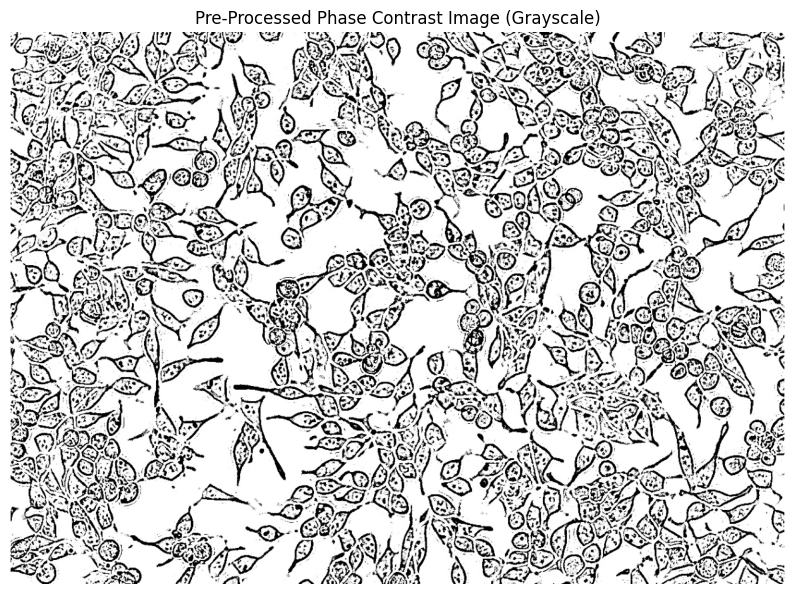

In [17]:
# --- 2. INITIAL VISUAL CHECK (Pre-Analysis) ---
plt.figure(figsize=(10, 8))
plt.imshow(gray, cmap='gray') # Use cmap='gray' for grayscale images
plt.title("Pre-Processed Phase Contrast Image (Grayscale)")
plt.axis('off')
plt.show()

In [18]:
# --- 3. ANALYSIS LOOP & CONTOUR FILTERING ---
all_areas = []
all_circularities = []
all_lengths = []
all_widths = []

# NEW: List to store contours that pass the filter
valid_contours = []

for contour in contours:
    # Calculate area BEFORE filtering
    area = cv2.contourArea(contour)

    # 1. Filter out very small particles (debris)
    if area > MIN_SIZE_THRESHOLD:

        # NEW: Store the contour that passed the filter
        valid_contours.append(contour)

        # Area and Perimeter
        perimeter = cv2.arcLength(contour, True)
        all_areas.append(area)

        # Circularity
        if perimeter > 0:
            circularity = 4 * np.pi * area / (perimeter * perimeter)
            all_circularities.append(circularity)

        # Length and Width (using fitted ellipse)
        if len(contour) >= 5: # Need at least 5 points to fit an ellipse
            (x, y), (minor_axis, major_axis), angle = cv2.fitEllipse(contour)
            all_lengths.append(major_axis)
            all_widths.append(minor_axis)

In [23]:
# --- 4. SUMMARIZE RESULTS ---
print(f"Total cells analyzed: {len(all_areas)}")
print(f"Average Area: {np.mean(all_areas):.2f}")
print(f"Average Circularity: {np.mean(all_circularities):.3f}")
print(f"Average Length: {np.mean(all_lengths):.2f}")

Total cells analyzed: 1072
Average Area: 170.03
Average Circularity: 0.206
Average Length: 52.64


In [27]:
# retrieve all data of cell area, length and circularity
data = {
    'Area_pixels': all_areas,
    'Circularity': all_circularities,
    'Length_pixels': all_lengths,
    # If you also collected all_widths, include it here:
    # 'Width_pixels': all_widths
}
df = pd.DataFrame(data)
print(df)

      Area_pixels  Circularity  Length_pixels
0            27.5     0.357956      19.360090
1            63.0     0.242709      19.465790
2            29.0     0.500989       8.309109
3            26.0     0.316252      13.522236
4            84.0     0.131490      26.828077
...           ...          ...            ...
1067         21.5     0.191550      15.145844
1068         25.5     0.602025      10.655654
1069         27.5     0.365996      14.257295
1070         38.5     0.096326      27.506351
1071         40.5     0.141176      23.278368

[1072 rows x 3 columns]


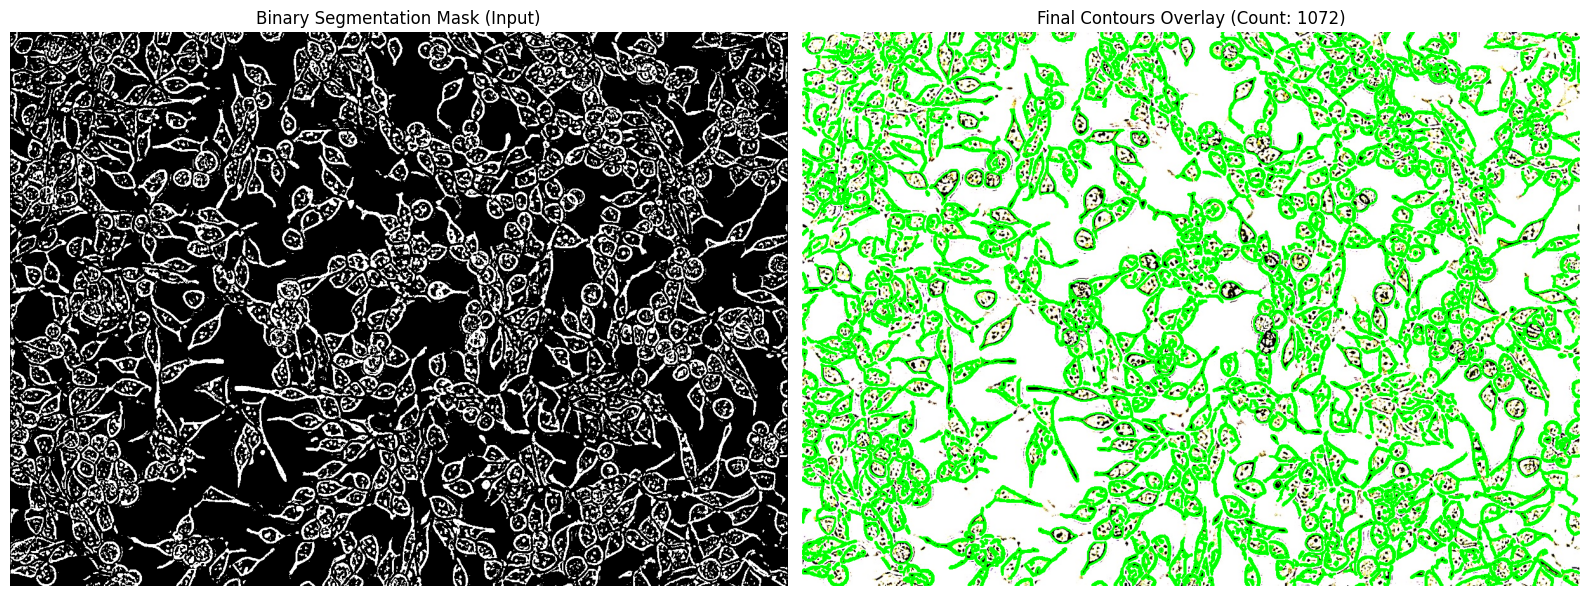

In [20]:
# --- 5. FINAL VISUALIZATION (Mask and Overlay) ---

# NEW: Create the image for the overlay drawing
# 1. Start with a copy of the original color image
draw_img = img.copy()

# 2. Draw the valid contours onto the copy (Green color: (0, 255, 0) in BGR)
cv2.drawContours(draw_img, valid_contours, -1, (0, 255, 0), 2)

# 3. Convert the resulting image to RGB for Matplotlib display
draw_img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

# Plotting the two validation images side-by-side
plt.figure(figsize=(16, 8))

# Subplot 1: Binary Segmentation Mask
plt.subplot(1, 2, 1)
plt.imshow(thresh, cmap='gray')
plt.title("Binary Segmentation Mask (Input)")
plt.axis('off')

# Subplot 2: Final Separated Contours Overlay (The Validation Check)
plt.subplot(1, 2, 2)
plt.imshow(draw_img_rgb)
plt.title(f"Final Contours Overlay (Count: {len(valid_contours)})")
plt.axis('off')

plt.tight_layout()
plt.show()